<a href="https://colab.research.google.com/github/kcarstons/backend_appraisals/blob/main/collab_llava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running Llava: a large multi-modal model on Google Colab

Run Llava model on a Google Colab!

Llava is a multi-modal image-text to text model that can be seen as an "open source version of GPT4". It yields to very nice results as we will see in this Google Colab demo.

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

The architecutre is a pure decoder-based text model that takes concatenated vision hidden states with text hidden states.

We will leverage QLoRA quantization method and use `pipeline` to run our model.

In [1]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install pypdfium2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.5 MB/s eta 0:00:00


## Load an image

Let's use the image that has been used for Llava demo

And ask the model to describe that image!

In [2]:
import requests
import pypdfium2 as pdfium
from PIL import Image
import os

#os.getcwd()

def extract_images(file_name):
    """
    Extract all images from a pdf and store in a list.
    """
    all_images = []
    pdf = pdfium.PdfDocument(file_name)

    for i in range(len(pdf)):
        page = pdf[i]

        for obj in page.get_objects():
            if obj.type == 3:
                image = obj.get_bitmap().to_pil()
                all_images.append(image)

    return all_images



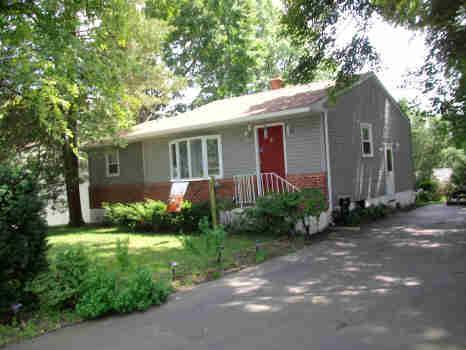

In [5]:
extracted_images_sf = extract_images("/content/appraisal_sf.pdf")
subject_images_sf = extracted_images_sf[3:12]
labels_sf = [ 'subject front', 'subject rear', 'subject street', 'kitchen', 'nook', 'living/dining', 'bedroom', 'bathroom', 'bathroom']
labeled_images_sf = [{'image':img, 'label': lbl} for img, lbl in zip(subject_images_sf, labels_sf)]

extracted_images_fha = extract_images("/content/fha_appraisal.pdf")
subject_images_fha = extracted_images_fha[11:18]
labels_fha = ['Subject Front', 'Subject Rear', 'Subject Street', 'Interior', 'Interior', 'Interior', 'Interior']
labeled_images_fha = [{'image':img, 'label': lbl} for img, lbl in zip(subject_images_fha, labels_fha)]

labeled_images_fha[0]['image']


## Preparing the quantization config to load the model in 4bit precision

In order to load the model in 4-bit precision, we need to pass a `quantization_config` to our model. Let's do that in the cells below

In [6]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

## Load the model using `pipeline`

We will leverage the `image-to-text` pipeline from transformers !

In [7]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [9]:
max_new_tokens = 200
prompt = "USER: <image>\nDescribe what I am looking at it in detail. Additionally, rate the general condition from a scale of very good, good, neutral, poor, very poor. \nASSISTANT:"


fha_captions = []
sf_captions = []

for item in labeled_images_fha:
    pil_image = item['image']
    label = item['label']
    caption = pipe(pil_image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    fha_captions.append(caption)

for item in labeled_images_sf:
    pil_image = item['image']
    label = item['label']
    caption = pipe(pil_image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    sf_captions.append(caption)





/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [10]:
print(fha_captions)


[[{'generated_text': 'USER:  \nDescribe what I am looking at it in detail. Additionally, rate the general condition from a scale of very good, good, neutral, poor, very poor. \nASSISTANT: The image features a small, well-maintained house with a red door. The house is situated on a street, surrounded by greenery. There are two potted plants in the front yard, one on the left side and the other on the right side of the house. A chair is placed on the left side of the house, and a bench is located on the right side. The overall condition of the house appears to be good, with well-maintained outdoor furniture and a neatly arranged front yard.'}], [{'generated_text': 'USER:  \nDescribe what I am looking at it in detail. Additionally, rate the general condition from a scale of very good, good, neutral, poor, very poor. \nASSISTANT: The image features a small, white house with a green roof, surrounded by a lush green field. The house is situated in a wooded area, with trees surrounding it. Th

In [11]:
print(sf_captions)

[[{'generated_text': 'USER:  \nDescribe what I am looking at it in detail. Additionally, rate the general condition from a scale of very good, good, neutral, poor, very poor. \nASSISTANT: The image features a large, modern-looking house with a wooden deck. The house is situated in a lush green field, giving it a serene and peaceful atmosphere. The deck is surrounded by a fence, providing a sense of security.\n\nThe house has a few potted plants placed around the deck, adding a touch of greenery to the scene. There are also a couple of chairs on the deck, inviting people to sit and enjoy the view.\n\nOverall, the house appears to be in good condition, with a well-maintained deck and a beautiful, natural setting.'}], [{'generated_text': 'USER:  \nDescribe what I am looking at it in detail. Additionally, rate the general condition from a scale of very good, good, neutral, poor, very poor. \nASSISTANT: The image features a large, modern-looking building with a brown roof. The building has 

The model has managed to successfully describe the image with accurate result ! We also support other variants of Llava, such as [`bakLlava`](https://huggingface.co/llava-hf/bakLlava-v1-hf) which should be all posted inside the [`llava-hf`](https://huggingface.co/llava-hf) organization on 🤗 Hub